In [1]:
import numpy as np
import matplotlib.pylab as plt

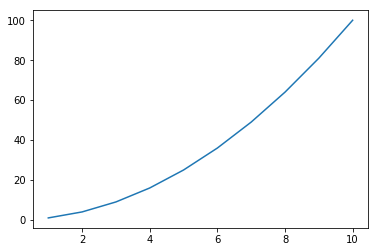

In [2]:
x=np.linspace(1,10,10)
y=x**2
plt.plot(x,y)

In [6]:
from lantz.messagebased import MessageBasedDriver


In [10]:
# -*- coding: utf-8 -*-
"""
    lantz.drivers.tektronix.tds1002B
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    Implements the drivers to control an oscilloscope.

    :copyright: 2012 by Lantz Authors, see AUTHORS for more details.
    :license: BSD, see LICENSE for more details.
    
    Source: Tektronix Manual
"""

from numpy import array, arange

from lantz.feat import Feat
from lantz.action import Action
from lantz.messagebased import MessageBasedDriver
#from lantz.visa import USBVisaDriver
from lantz.errors import InvalidCommand

class TDS1002B(MessageBasedDriver):
    """Tektronix TDS1002B 60MHz 2 Channel Digital Storage Oscilloscope
    """
    ENCODING = 'ascii'

    RECV_TERMINATION = '\n'
    SEND_TERMINATION = '\n'
    TIMEOUT = -1    # Avoids timeout while acquiring a curve. May not be the 
                    # best option.
        
    @Action()
    def initiate(self):
        """ Initiates the acquisition in the osciloscope.
        """
        self.send(':ACQ:STATE ON')
            
    @Feat(read_once=True)
    def idn(self):
        """ Identify the Osciloscope
        """
        return self.query('*IDN?')
        
    @Action()
    def autoset(self):
        """ Adjust the vertical, horizontal and trigger controls to display a 
            stable waveform.
        """
        self.send('AUTOS EXEC')
    
    @Action()
    def autocal(self):
        """ Autocalibration of osciloscope. It may take several minutes to 
            complete
        """
        return self.send('*CAL')
       
    @Feat(limits=(1,2))
    def datasource(self):
        """ Retrieves the data source from which data is going to be taken. 
            TDS1012 has 2 channels
        """
        return self.query('DAT:SOU?')
    
    @datasource.setter
    def datasource(self,value):
        """ Sets the data source for the acquisition of data.
        """
        self.send('DAT:SOU CH{}'.format(value))
    
    @Action()
    def acquire_parameters(self):
        """ Acquire parameters of the osciloscope.
            It is intended for adjusting the values obtained in acquire_curve
        """
        values = 'XZE?;XIN?;PT_OF?;YZE?;YMU?;YOF?;'
        answer = self.query('WFMP:{}'.format(values))
        parameters = {}
        for v, j in zip(values.split('?;'), answer.split(';')):
            parameters[v] = float(j)#.split(' ', 1)[1])
        return parameters
    
    @Action()
    def data_setup(self):
        """ Sets the way data is going to be encoded for sending. 
        """
        self.send('DAT:ENC ASCI;WID 2') #ASCII is the least efficient way, but
                                        # couldn't make the binary mode to work

    @Action()
    def acquire_curve(self, start=1, stop=100):
        """ Gets data from the oscilloscope. It accepts setting the start and 
            stop points of the acquisition (by default the entire range).
        """
        parameters = self.acquire_parameters()
        self.data_setup() 
        self.send('DAT:STAR {}'.format(start))
        self.send('DAT:STOP {}'.format(stop))
        data = self.query('CURV?')
        data = data[6:].split(',')
        data = array(list(map(float, data)))
        ydata = (data - parameters['YOF']) * parameters['YMU']\
                + parameters['YZE']
        xdata = arange(len(data))*parameters['XIN'] + parameters['XZE']
        return list(xdata), list(ydata)
        
    
    @Action()
    def forcetrigger(self):
        """ Creates a trigger event. 
        """
        self.send('TRIG:FORC')
        return
        
    @Action()
    def triggerlevel(self):
        """ Sets the trigger level to 50% of the minimum and maximum values of 
            the signal. 
        """
        self.send('TRIG:MAI SETL')
    
    @Feat(values={'AUTO', 'NORMAL'})
    def trigger(self):
        """ Retrieves trigger state.
        """
        return self.query('TRIG:MAIN:MODE?')
    
    @trigger.setter
    def trigger(self,state):
        """ Sets the trigger state.
        """
        self.send('TRIG:MAI:MOD {}'.format(state))
        return
        
    @Feat()
    def horizontal_division(self):
        """ Horizontal time base division. 
        """
        return float(self.query('HOR:MAI:SCA?'))
    
    @horizontal_division.setter
    def horizontal_division(self,value):
        """ Sets the horizontal time base division. 
        """
        self.send('HOR:MAI:SCA {}'.format(value))
        return
        
    @Feat(values={0, 4, 16, 64, 128})
    def number_averages(self):
        """ Number of averages
        """
        answer = self.query('ACQ?')
        answer = answer.split(';')
        if answer[0] == 'SAMPLE':
            return 0
        elif answer[0] == 'AVERAGE':
            return int(self.query('ACQ:NUMAV?'))
        else:
            raise InvalidCommand
    
    @number_averages.setter
    def number_averages(self,value):
        """ Sets the number of averages. If 0, the it is a continous sample.
        """
        if value == 0:
            self.send('ACQ:MOD SAMPLE')
        else:
            self.send('ACQ:MOD AVE;NUMAV {}'.format(value))
        
    @Action(values={'FREQ', 'MINI', 'MAXI', 'MEAN'})
    def _measure(self, mode):
        """ Measures the Frequency, Minimum, Maximum or Mean of a signal.
        """
        self.send('MEASU:IMM:TYP {}'.format(mode))
        return float(self.query('MEASU:IMM:VAL?'))
    
    def measure_mean(self):
        """ Gets the mean of the signal.
        """
        answer = self._measure('MEAN')
        return answer
 
    def measure_frequency(self):
        """ Gets the frequency of the signal.
        """
        answer = self._measure('FREQ')
        return answer
        
    def measure_minimum(self):
        """ Gets the minimum of the signal.
        """
        answer = self._measure('MINI')
        return answer        
       
    def measure_maximum(self):
        """ Gets the mean of the signal.
        """
        answer = self._measure('MAXI')
        return answer

In [33]:
import visa

In [22]:
help(pyvisa)

Help on package pyvisa:

NAME
    pyvisa

DESCRIPTION
    pyvisa
    ~~~~~~
    
    Python wrapper of National Instrument (NI) Virtual Instruments Software
    Architecture library (VISA).
    
    This file is part of PyVISA.
    
    :copyright: 2014 by PyVISA Authors, see AUTHORS for more details.
    :license: MIT, see LICENSE for more details.

PACKAGE CONTENTS
    attributes
    compat (package)
    constants
    ctwrapper (package)
    errors
    highlevel
    resources (package)
    rname
    shell
    testsuite (package)
    thirdparty (package)
    util

FUNCTIONS
    log_to_screen(level=10)

DATA
    absolute_import = _Feature((2, 5, 0, 'alpha', 1), (3, 0, 0, 'alpha', 0...
    division = _Feature((2, 2, 0, 'alpha', 2), (3, 0, 0, 'alpha', 0), 8192...
    logger = <Logger pyvisa (WARNING)>
    print_function = _Feature((2, 6, 0, 'alpha', 2), (3, 0, 0, 'alpha', 0)...
    unicode_literals = _Feature((2, 6, 0, 'alpha', 2), (3, 0, 0, 'alpha', ...

VERSION
    1.9.1

FILE
    /usr

In [24]:
# Listo los VISA resources disponibles
rm = visa.ResourceManager()
print(rm.list_resources())

#: VISA Resources Reemplazar por el que tengas
resource_name = 'USB0::0x0699::0x0363::C065087::INSTR'

#: Numero de pantallas a tomar
repeticiones = 20

#: Indica si deber
plotear = False

#: Cuanta de eventos por pantalla
eventos = []

#: Altura de picos
amplitudes = []

# Abro la sesion con el osciloscopio
with TDS1002B(resource_name) as osc:

    # Levanto n pantallas y en cada una registro el número de máximos
    for i in range(repeticiones):

        tiempo, voltaje = osc.acquire_curve()

        # Busco máximos
        peakind = signal.find_peaks_cwt(voltaje, np.arange(0.1,1), min_snr=50)

        eventos.append(np.size(peakind))

        amplitudes.extend((voltaje[j] for j in peakind) )


#%% Histogramas
if plotear:
    import matplotlib.pyplot as plt

    tiempo, voltaje = osc.acquire_curve()
    plt.plot(tiempo, voltaje, '.')
    plt.show()

    # Para hacer un histograma de eventos:
    plt.hist(eventos)
    plt.show()

    # Para hacer un histograma de amplitudes (para sacar la tensión umbral, por ejemplo)

    plt.hist(amplitudes)
plt.show()

()


AttributeError: module 'visa' has no attribute 'ResourceManager'

In [34]:
rm = visa.ResourceManager()
rm.list_resources()

AttributeError: module 'visa' has no attribute 'ResourceManager'

In [27]:
help(visa.ResourceManager())

Help on ResourceManager in module pyvisa.highlevel object:

class ResourceManager(builtins.object)
 |  VISA Resource Manager
 |  
 |  :param visa_library: VisaLibrary Instance, path of the VISA library or VisaLibrary spec string.
 |                       (if not given, the default for the platform will be used).
 |  
 |  Methods defined here:
 |  
 |  __del__(self)
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  __str__(self)
 |      Return str(self).
 |  
 |  close(self)
 |      Close the resource manager session.
 |  
 |  get_instrument = open_resource(self, resource_name, access_mode=<AccessModes.no_lock: 0>, open_timeout=0, resource_pyclass=None, **kwargs)
 |  
 |  ignore_warning(self, *warnings_constants)
 |      Ignoring warnings context manager for the current resource.
 |      
 |      :param warnings_constants: constants identifying the warnings to ignore.
 |  
 |  list_resources(self, query='?*::INSTR')
 |      Returns a tuple of all connected devices matching que